# Семинар 1-6: Крупноблочная $HP$-модель

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import Bio.PDB as pdb

from hp_model.utils.sequence import HPSequenceManager
from hp_model.lattice import PseudoTriangularLattice, FCC3DLattice

# 0. Подготовка

На этом семинаре будем работать с 2D $HP$-моделью. 

И сразу прыгнем с места в карьер - прочитаем белок 1FSD и сделаем из него $HP$-последовательность:

In [3]:
fpath = pdb.PDBList().retrieve_pdb_file("1fsd", 
                                        file_format="pdb")

In [8]:
chain = pdb.PDBParser().get_structure("s", fpath)[0].child_list[0]

In [9]:
hp_sequence = HPSequenceManager(pdb_chain=chain).get_hp_sequence()

In [10]:
hp_sequence

'PPPPHPHPHPPHPPPPPHPPHHPPHPHP'

Получим координаты всех $C_\alpha$:

In [12]:
ca_coords = np.array([res["CA"].coord for res in chain])

# 1. Построение максимально плотного ядра

In [14]:
from hp_model.prediction.hcore_generation.lp_generation import make_cores
from hp_model.plotting import Plotter

Сколько $H$-мономеров в $HP$-последовательности?

In [16]:
hp_sequence.count("H")

9

Сгенерируем максимально плотные ядра для данной $HP$-последовательности:

In [20]:
cores = make_cores(hp_sequence, None, False)

OBJECTIVE: 16.0


Сколько получилось ядер? Отрисуем их и визуально сравним!

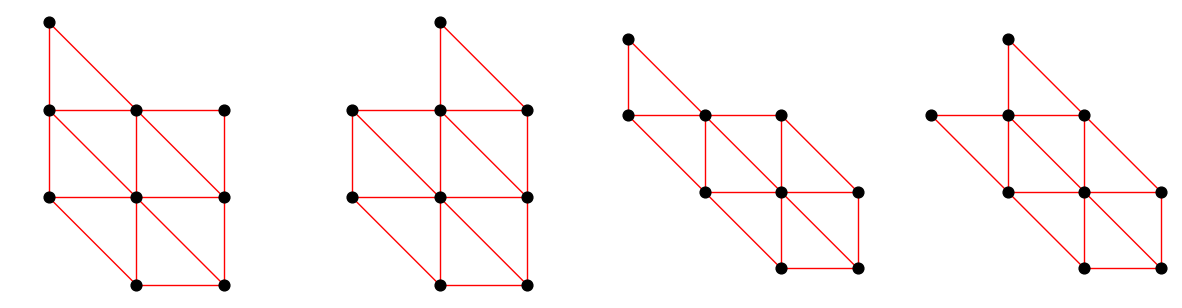

In [18]:
fig, axs = plt.subplots(1, len(cores), figsize=(15, 15 / len(cores)))

for i, core in enumerate(cores):
    Plotter.plot_hcore(axs[i], 
                       core)
    axs[i].axis("equal")
    axs[i].axis("off")

plt.show()

**Вопрос для обсуждения**: Если ядер получилось несколько, разные ли они?

К слову: <a href="https://projectswhynot.site/draggable_lattice_points/">давайте поиграем 🙂</a>

Посмотрим внимательнее на $HP$-последовательность. Может ли быть такое, что **ни в одно из этих ядер** белок 1FSD не фитится? 🤔

Разделим блоки, состоящие из нескольких последовательных $P$ и $H$ в $HP$-последовательности друг от друга:

In [21]:
print(hp_sequence.replace("HP", "H-P").replace("PH", "P-H"))

PPPP-H-P-H-P-H-PP-H-PPPPP-H-PP-HH-PP-H-P-H-P


**Вопрос для обсуждения**: Можно ли здесь что-то увидеть? 🤔

**Напоминание**: в $H$-ядре не могут находиться $P$-мономеры!

# 2. Оценка максимального числа контактов в $H$-ядре для данной $HP$-последовательности

Сколько контактов в полученных ядрах?

In [23]:
for core in cores:
    print(core.n_contacts)

16
16
16
16


Мы поняли, что в таких ядрах разместить белок нельзя. А сколько контактов может быть в ядре, в котором разместить белок **можно**?

## 2.1. Посчитаем "периметр" $H$-ядра:

Можно заметить, что ядро - планарный граф с $N$ вершинами, $K$ ребрами (контактами) и $G$ гранями, $(G - 1)$ из которых треугольные. Обозначим число вершим на поверхности $H$-ядра как $R$.

Тогда $N - K + G = 2$; (по ф-ле Эйлера)

$2K = 3(G - 1) + R$;

Тогда $R = 3N - K - 3$,

а число точек **внутри** $H$-ядра: $N_{in} = N - R = K - 2N + 3$

Вычислим $R$ и $N_{in}$ для первого максимально плотного ядра:

In [34]:
N = hp_sequence.count("H")

In [35]:
K = cores[0].n_contacts
R = 3 * N - K - 3
Nin = N - R

print(R, Nin)

8 1


## 2.2. А есть ли в $HP$-последовательности такой $H$-мономер, который мог бы находиться внутри $H$-ядра (быть внутренней точкой)? 🤔

In [36]:
from hp_model.prediction.protein_fitting.csp_fitting.csp import ConstraintBuilder

In [37]:
check_verdict = ConstraintBuilder(hp_sequence, cores[0], PseudoTriangularLattice()).check_feasibility(verbose=True)

Если значение check_verdict["max_H-P_dist"] $\leq$ $N_{in}$, то нет такого мономера!

In [38]:
print(check_verdict["max_H-P_dist"])

1


$\rightarrow$ 😕

## 2.3. Тогда какое число контактов допустимо? 🤔

In [39]:
from hp_model.hcore.filtering._2d.kmax_filtering import get_Kmax

In [40]:
K_max = get_Kmax(hp_sequence)
print(K_max)

15


Сделаем ядра, подходящие под это требование!

In [41]:
cores = make_cores(hp_sequence, K_max, False)

OBJECTIVE: 15.0


И снова их отрисуем:

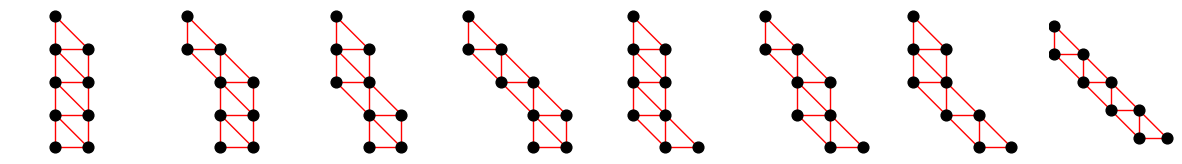

In [42]:
fig, axs = plt.subplots(1, len(cores), figsize=(15, 15 / len(cores)))

for i, core in enumerate(cores):
    Plotter.plot_hcore(axs[i], 
                       core)
    axs[i].axis("equal")
    axs[i].axis("off")

plt.show()

$\rightarrow$ Лучше? Лууучше 😉

## 3. Разместим белок в ядре!

Вообще, правильно проверить возможность размещения белка в каждом из сгенерированных ядер.

...но мы ограничимся первым 🙂 Его достаточно!

In [43]:
from hp_model.prediction.protein_fitting.csp_fitting.fitting import fit_protein

In [48]:
mapping = fit_protein(hp_sequence, cores[1])

In [49]:
print(mapping)

{'L_11': [2.0, 5.0], 'L_10': [3, 4], 'L_12': [2, 4], 'L_9': [3, 5], 'L_8': [2.0, 6.0], 'L_7': [3, 6], 'L_6': [2.0, 7.0], 'L_5': [2, 8], 'L_4': [1.0, 8.0], 'L_3': [1, 9], 'L_13': [2, 3], 'L_2': [0, 10], 'L_1': [1, 10], 'L_0': [2, 10], 'L_14': [2, 2], 'L_15': [1, 3], 'L_16': [1, 4], 'L_17': [1.0, 5.0], 'L_18': [0, 5], 'L_19': [0, 6], 'L_20': [1.0, 6.0], 'L_21': [1.0, 7.0], 'L_22': [0, 7], 'L_23': [-1, 8], 'L_24': [0.0, 8.0], 'L_25': [-1, 9], 'L_26': [0.0, 9.0], 'L_27': [-1, 10]}


Отрисуем, что получилось!

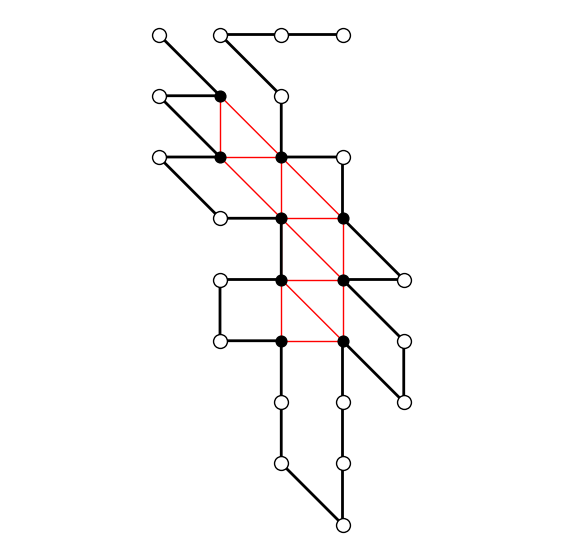

In [50]:
_, ax = plt.subplots(1,1,figsize=(7,7))
Plotter.plot_fit(ax, cores[1], hp_sequence, mapping)

ax.axis("equal")
ax.axis("off")

plt.show()

# 3.1. Ради научного интереса сравним с реальными позициями $C_\alpha$!

**Замечание**: Расстояние между соседними $C_\alpha$ - 3.83 ангстрем. А между соседними узлами решетки - $\sqrt{2}$ 🤔

Поменяем масштаб для узлов решетки:

In [51]:
pred_cas = np.array([mapping[f"L_{i}"] for i in range(len(hp_sequence))])

In [55]:
pred_cas = (pred_cas - pred_cas.mean(axis=0)) / np.sqrt(2) * 3.83

А еще у нас предсказанные координаты на плоскости 🤔 Добавим нулевой столбец координаты $z$:

In [60]:
pred_cas = np.hstack((pred_cas, np.zeros((len(pred_cas), 1))))

**Готово!** Посчитаем RMSD:

In [61]:
from Bio.PDB.QCPSuperimposer import QCPSuperimposer

In [65]:
h_inds = [i for i in range(len(hp_sequence)) if hp_sequence[i] == 'H']

In [66]:
h_inds

[4, 6, 8, 11, 17, 20, 21, 24, 26]

In [67]:
imposer = QCPSuperimposer()
imposer.set(ca_coords[h_inds], pred_cas[h_inds])
imposer.run()
imposer.rms

4.6707098415385415

**Вопрос для обсуждения**: хорош ли этот результат? 🤔